In [35]:
from typing import TypedDict, Annotated
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import ChatPromptTemplate

_ = load_dotenv()

llm = ChatOpenAI(model="gpt-4o", temperature=0)


class State(TypedDict):
    application: str
    experience_level: str
    skill_match: str
    response: str


workflow = StateGraph(State)


def categorize_experience(state: State) -> State:
    print(f"\n Categorizing Candidate Experience..")
    prompt = ChatPromptTemplate.from_template(
        "Based on the following categorize the candidate as 'Entry-level', 'Mid-level' or 'Senior-level"
        "Application:{application}"
    )

    chain = prompt | llm
    experience_level = chain.invoke({"application": state["application"]}).content
    print(f"\n Experience leavel: {experience_level}")
    return {"experience_level": experience_level}


def assess_skillset(state: State) -> State:
    print(f"\n Assessing skill set of the candidate")
    prompt = ChatPromptTemplate.from_template(
        "Based on the job application for a Python Developer, assess the candidate's skillset"
        "Respond with either 'Match' or 'No Match'"
        "Application : {application}"
    )

    chain = prompt | llm
    skill_match = chain.invoke({"application": state["application"]}).content
    print(f"Skill match : {skill_match}")
    return {"skill_match": skill_match}


def schedule_hr_interview(state: State) -> State:
    print("\nScheduling HR interview")
    return {"response": "Candidate has been shortlisted for an HR interview."}


def escalate_to_recruiter(state: State) -> State:
    print("Escalating to recruiter")
    return {"response": "Candidate has senior-level experience but doesn't match job skills."}


def reject_application(state: State) -> State:
    print("Sending rejecting email")
    return {"response": "Candidate doesn't meet JD and has been rejected."}


def route_app(state: State) -> str:
    if (state["skill_match"] == "Match"):
        return "schedule_hr_interview"
    elif ("Senior-level" in state["experience_level"] ):
        return "escalate_to_recruiter"
    else:
        return "reject_application"


workflow.add_node("categorize_experience", categorize_experience)
workflow.add_node("assess_skillset", assess_skillset)
workflow.add_node("schedule_hr_interview", schedule_hr_interview)
workflow.add_node("escalate_to_recruiter", escalate_to_recruiter)
workflow.add_node("reject_application", reject_application)

workflow.add_edge("categorize_experience", "assess_skillset")
workflow.add_conditional_edges("assess_skillset", route_app)
workflow.add_edge(START, "categorize_experience")
workflow.add_edge("assess_skillset", END)
workflow.add_edge("schedule_hr_interview", END)
workflow.add_edge("escalate_to_recruiter", END)
workflow.add_edge("reject_application", END)


app = workflow.compile()


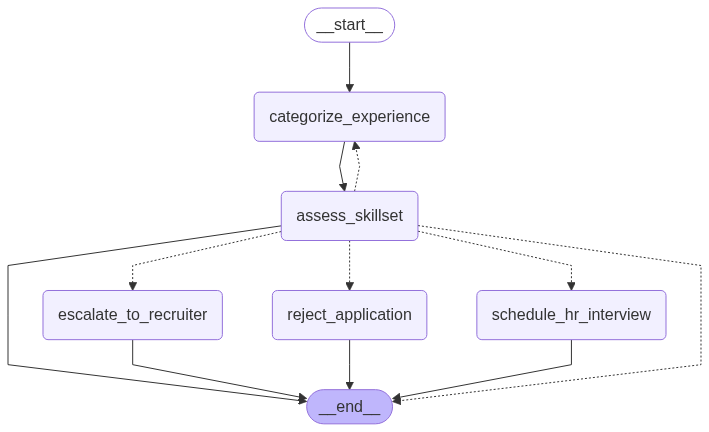

In [36]:
from IPython.display import Image, display

display(
    Image(
        app.get_graph().draw_mermaid_png()
    )
)

In [37]:
def run_candidate_screening(application: str):
  results = app.invoke({"application" : application})
  return {
      "experience_level" : results["experience_level"],
      "skill_match" : results["skill_match"],
      "response" : results["response"]
  }

In [40]:
application_text = "I have 2 years of experience in software engineering with expertise in Python"
results = run_candidate_screening(application_text)
print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


 Categorizing Candidate Experience..

 Experience leavel: Based on the information provided, the candidate would be categorized as 'Entry-level'. Typically, entry-level positions are for individuals with 0-2 years of experience. Since the candidate has 2 years of experience, they fall within this range.

 Assessing skill set of the candidate
Skill match : Match

Scheduling HR interview


Computed Results :
Application: I have 2 years of experience in software engineering with expertise in Python
Experience Level: Based on the information provided, the candidate would be categorized as 'Entry-level'. Typically, entry-level positions are for individuals with 0-2 years of experience. Since the candidate has 2 years of experience, they fall within this range.
Skill Match: Match
Response: Candidate has been shortlisted for an HR interview.
